## Install Modules

In [1]:
# install torch
# !pip install ultralytics

In [2]:
# use labelimg repo/tool to annotate the images

## Import Modules

In [3]:
import os
import time
import random
import pandas as pd
import numpy as np
import cv2
import torch
from tqdm.auto import tqdm
from PIL import Image
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Dataset

In [4]:
df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
# get image_id
df['image_id'] = df['image'].apply(lambda x: x.split('.')[0])
df['classes'] = 0
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0


In [6]:
# initialize configuration
img_h, img_w, num_channels = (380, 676, 3)
images_folder = 'data/training_images/'

In [7]:
# convert the data points to YOLO format
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']

In [8]:
# normalize the values
df['x_center'] = df['x_center'] / img_w
df['y_center'] = df['y_center'] / img_h
df['w'] = df['w'] / img_w
df['h'] = df['h'] / img_h

In [9]:
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes,x_center,y_center,w,h
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0,0.100217,0.557191,0.155572,0.129987


## Exploratory Data Analysis

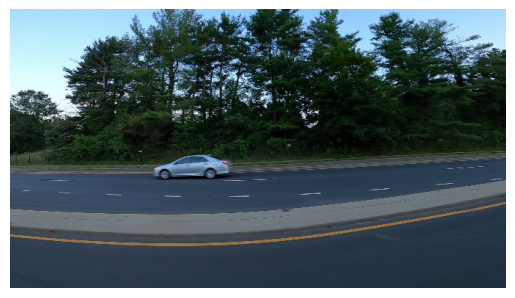

In [10]:
image = random.choice(df['image'])
image_path = os.path.join(images_folder, image)
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)
plt.show()

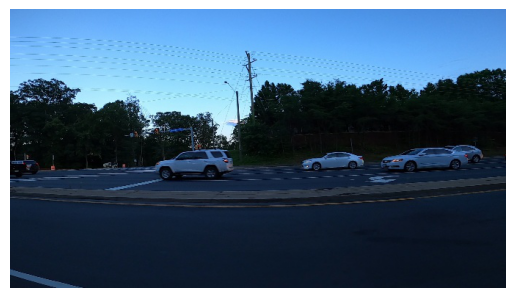

In [11]:
image = random.choice(df['image'])
image_path = os.path.join(images_folder, image)
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)
plt.show()

In [12]:
def draw_bounding_box(idx):
    image = cv2.imread(os.path.join(images_folder, df['image'][idx]))
    x_min = int(df['xmin'][idx])
    y_min = int(df['ymin'][idx])
    x_max = int(df['xmax'][idx])
    y_max = int(df['ymax'][idx])

    # draw the rectangle
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # place the label above bounding boxes
    cv2.putText(image, 'car', (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

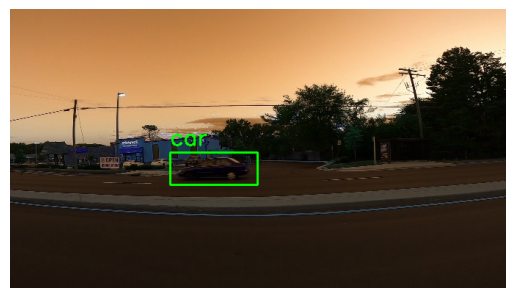

In [13]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

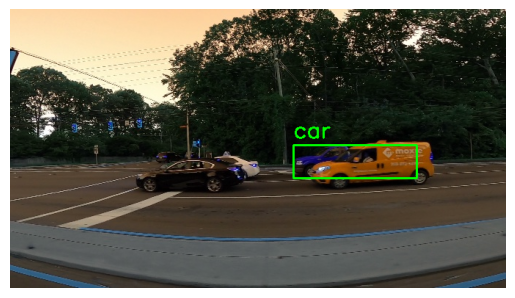

In [14]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

## Create Annotations for YOLO Format

In [15]:
annotations_folder = 'data/annotations/'

if not os.path.exists(annotations_folder):
    os.mkdir(annotations_folder)

In [16]:
annotations_dict = {}

# iterate through dataframe to consolidate bounding boxes for each image
for _, row in df.iterrows():
    image_file = row['image']
    class_label = int(row['classes'])
    x_center = row['x_center']
    y_center = row['y_center']
    w = row['w']
    h = row['h']

    # initialize list if image is not present in dicitionary
    if image_file not in annotations_dict:
        annotations_dict[image_file] = []

    # append annotations to the list 
    annotations_dict[image_file].append(f"{class_label} {x_center} {y_center} {w} {h}")

# write the annotations in text file
for image_file, annotations in annotations_dict.items():
    annotation_file = os.path.join(annotations_folder, os.path.splitext(image_file)[0] + '.txt')
    with open(annotation_file, 'w') as f:
        for annotation in annotations:
            f.write(annotation + '\n')

In [17]:
# split images for training and testing
from sklearn.model_selection import train_test_split
images = list(annotations_dict.keys())
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

In [18]:
# create folders for train and test
train_images_folder = 'datasets/train_images'
test_images_folder = 'datasets/test_images'
train_annotations_folder = 'datasets/train_annotations'
test_annotations_folder = 'datasets/test_annotations'

# create directors for the above paths
os.mkdir('datasets')
os.mkdir(train_images_folder)
os.mkdir(test_images_folder)
os.mkdir(train_annotations_folder)
os.mkdir(test_annotations_folder)

In [19]:
# copy the files to the respective folder paths
def copy_files(images_list, image_src_folder, annotation_src_folder, image_dest_folder, annotation_dest_folder):
    for image_file in images_list:
        # path for source and destination
        src_image_path = os.path.join(image_src_folder, image_file)
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        src_annotations_path = os.path.join(annotation_src_folder, annotation_file)
        dest_image_path = os.path.join(image_dest_folder, image_file)
        dest_annotation_path = os.path.join(annotation_dest_folder, annotation_file)

        # copy images
        shutil.copy2(src_image_path,  dest_image_path)
        # copy annotations
        shutil.copy2(src_annotations_path, dest_annotation_path)


In [20]:
copy_files(train_images, images_folder, annotations_folder, train_images_folder, train_annotations_folder)
copy_files(test_images, images_folder, annotations_folder, test_images_folder, test_annotations_folder)

## Model Training

In [21]:
from ultralytics import YOLO
# load pretrained model
model = YOLO('yolov8n.yaml')

# define training parameters
model.train(data='data.yaml', epochs=50, batch=16, imgsz=676, workers=2)

New https://pypi.org/project/ultralytics/8.2.68 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.66  Python-3.12.3 torch-2.4.0 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=676, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

C:\Users\Aswin\anaconda3\Lib\site-packages\ultralytics\engine\trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\train_im


train: New cache created: D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\train_images.cache


val: Scanning D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\test_image

val: New cache created: D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\test_images.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 2 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.58G      4.802      5.365      4.228         25        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.58G      3.708      4.318      3.925         44        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.58G       2.99      3.268      3.365         30        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.58G      2.648      2.612      2.806         33        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.58G      2.421      2.361      2.515         31        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.58G       2.27      2.136      2.329         43        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.58G      2.201      2.009      2.296         39        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119   0.000552     0.0504   0.000351   0.000139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.58G      2.104      1.779       2.18         25        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.637     0.0588      0.137     0.0481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.58G      2.066       1.64      2.125         29        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.611       0.41       0.45      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.58G      2.054      1.615      2.116         52        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.817      0.655      0.767      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.58G      1.934      1.443      2.019         30        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.738      0.779      0.765      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.58G      1.862      1.345      1.945         27        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.862       0.84      0.902      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.58G      1.855      1.358       1.97         21        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.86      0.778      0.876      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.58G      1.748      1.237      1.845         35        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.953      0.856      0.924      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.58G      1.736      1.205      1.811         43        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.876      0.891      0.915      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.58G      1.662      1.109       1.78         28        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.924       0.84      0.921      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.58G      1.656       1.12      1.771         39        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.96      0.807      0.916      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.58G      1.643      1.066      1.763         37        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.953       0.84       0.94      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.58G      1.609      1.025      1.709         21        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.936      0.908      0.944      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.58G      1.603      1.017      1.722         22        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.953      0.846       0.91       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.58G      1.576      1.009      1.701         27        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.981      0.848      0.941       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.58G      1.565     0.9774      1.698         34        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.963      0.866      0.956      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.58G      1.619     0.9488      1.726         41        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.921      0.885       0.95       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.58G      1.543     0.9321      1.639         38        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.959      0.899      0.958      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.58G      1.554     0.9106      1.636         33        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.92      0.916      0.955      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.58G      1.504     0.8987      1.595         29        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.987      0.891      0.953      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.58G      1.522     0.9251      1.643         30        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.974      0.891      0.946      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.58G       1.49     0.8887      1.596         42        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.931      0.907      0.945      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.58G      1.527      0.916      1.613         51        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.931      0.916      0.952      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.58G      1.481     0.8685      1.614         32        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.925      0.932      0.949      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.58G      1.469     0.8318      1.571         34        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.977      0.924      0.952      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.58G      1.422     0.8208      1.579         28        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.958      0.899       0.95      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.58G      1.408     0.8027      1.523         28        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.947      0.907      0.954      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.58G      1.439     0.8083      1.606         34        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.927      0.899       0.95       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.58G      1.398     0.7983       1.51         41        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.982      0.903       0.96      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.58G      1.401     0.7645      1.526         46        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.98      0.933      0.956      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.58G      1.382     0.7625      1.507         30        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.972      0.924      0.956      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.58G      1.358     0.7435      1.494         36        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.97      0.916      0.954       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.58G      1.376     0.7575      1.494         49        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.985      0.916      0.964      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.58G      1.362     0.7527      1.485         25        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.985      0.916      0.968       0.63


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G      1.317     0.8025      1.537         15        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.982      0.907      0.965      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.58G      1.296     0.7658      1.492         15        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.972      0.908      0.959      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.58G      1.294     0.7724      1.522         18        704: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.956      0.916      0.955      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.58G      1.254     0.7474      1.501         25        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.982       0.93      0.962       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.58G      1.233     0.7139      1.479         15        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.983      0.924      0.963      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.58G      1.268     0.7314       1.49         11        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119       0.99      0.924      0.963      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.58G      1.238      0.717      1.464         19        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.989      0.924      0.965       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.58G       1.21      0.698      1.447         19        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.989      0.916      0.963      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.58G       1.24     0.7071      1.498         22        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.991      0.922      0.966      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.58G      1.209     0.7075      1.449         12        704: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         71        119      0.988      0.924      0.965      0.623



50 epochs completed in 0.180 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.66  Python-3.12.3 torch-2.4.0 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         71        119      0.985      0.916      0.968       0.63
Speed: 0.3ms preprocess, 6.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001652B6D1310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [24]:
metrics = model.val()

Ultralytics YOLOv8.2.66  Python-3.12.3 torch-2.4.0 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\test_image
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<0


                   all         71        119      0.985      0.916      0.968      0.633
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train2


In [28]:
# # load the weights
# best_model = YOLO('yolov8n.yaml')
# best_model.load('runs/detect/train/weights/best.pt')

## Test with Real Image


image 1/1 D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\test_images\vid_4_10020.jpg: 416x704 1 car, 103.3ms
Speed: 2.5ms preprocess, 103.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 704)


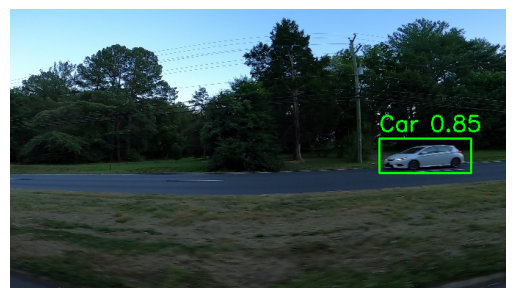

In [50]:
# process the results
image_path = 'datasets/test_images/vid_4_10020.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()


image 1/1 D:\notebooks\Data Science Projects\Deep Learning\Custom Object Detection using YOLOv8\datasets\test_images\vid_4_26360.jpg: 416x704 4 cars, 112.7ms
Speed: 4.5ms preprocess, 112.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 704)


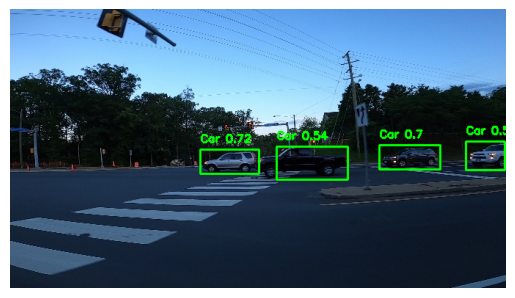

In [49]:
# process the results
image_path = 'datasets/test_images/vid_4_26360.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()